## Show the propagator from the calculated correlator.

In [1]:
import os, sys
import numpy as np
from pathlib import Path
from cosmoprimo.fiducial import DESI
from pyrecon.metrics import MeshFFTCorrelator, MeshFFTPropagator, CatalogMesh 

In [2]:
import matplotlib.pyplot as plt

## For the IC with particles regularly spaced, there should be no shot noise

In [3]:
def read_correlator(data_dir, filename, bias):
    data_fn = Path(data_dir, filename)
    print("Read file:", data_fn)
    correlator = MeshFFTCorrelator.load(data_fn)  
    correlator.source_auto_initial.poles.shotnoise_nonorm = 0.  # <= setting shotnoise to 0
    propagator = correlator.to_propagator(growth=bias)
    transfer = correlator.to_transfer(growth=bias)
    return correlator, transfer, propagator

In [4]:
def cal_Sigma_xy(C_MG, beta, Sigma_sm, convention, k=0.2, mu=0.0):
    if convention == "reciso":
        S_k = np.exp(-(k*Sigma_sm)**2.0/2.0)
        kaiser_term = 1 + beta * mu**2 * (1 - S_k)
    else:
        ## include the convention == "recsym" or "pre-recon"
        kaiser_term = 1 + beta * mu**2

    #print("C/kaiser:", C_MG/kaiser_term)
    Sigma_xy = (-4*np.log(C_MG/kaiser_term)/(k*k * (1-mu**2)))**0.5
    return Sigma_xy

def cal_Sigma_z(C_MG, beta, Sigma_sm, convention, k=0.2, mu=1.0):
    if convention == "reciso":
        S_k = np.exp(-(k*Sigma_sm)**2.0/2.0)
        kaiser_term = 1 + beta * mu**2 * (1 - S_k)
    else:
        ## include the convention == "recsym" or "pre-recon"
        kaiser_term = 1 + beta * mu**2

    #print("C/kaiser:", C_MG/kaiser_term)

    Sigma_z = (-4*np.log(C_MG/kaiser_term)/(k*mu)**2)**0.5
    return Sigma_z

def cal_propagator(k, mu, beta, Sigma_sm, convention, Sigma_xy, Sigma_z):
    if convention == "reciso":
        S_k = np.exp(-(k*Sigma_sm)**2.0/2.0)
        kaiser_term = 1 + beta * mu**2 * (1 - S_k)
    else:
        ## include the convention == "recsym" or "pre-recon"
        kaiser_term = 1 + beta * mu**2

    C_MG = kaiser_term * np.exp(-k*k*((1-mu**2) * Sigma_xy**2 + mu**2 * Sigma_z**2)/4.0)
    return C_MG

In [5]:
cap = 'ngc'
zmin, zmax = 0.4, 0.6
recon_nmesh = 512

# zmin, zmax = 0.6, 0.8
# recon_nmesh = 1024

# zmin, zmax = 0.8, 1.1
# recon_nmesh = 1024

Nmesh = 1024
#Nmesh = 512
recon_algo = "MultiGrid"
#recon_algo = "IterativeFFT"  # "MultiGrid"
#recon_algo = "IterativeFFTParticle" 


nzweight_dir = "with_nzweight/"

#convention_list = ["pre_recon", "reciso", "recsym"]
convention = "reciso"
#convention = "recsym"

sm_radius_list = [7.5, 10, 15]
ls_list = ['-', '--', '--']

niter = 3
zcubic = 0.8      # the snapshot of a cubic box used for the cutsky mock
# rescale IC density to low z
zeff = (zmin + zmax)/2.0

cosmo = DESI()
growth_rate = cosmo.hubble_function(zcubic)/cosmo.hubble_function(zeff) * (1+zeff)/(1+zcubic) * cosmo.growth_rate(zcubic)
bias = 1.99
beta = growth_rate/bias

data_dir = "/pscratch/sd/j/jerryou/y1_mockchallenge/propagator/cutsky/LRG/new_IC/with_nzweight/set_nmesh/"
##idir0 = "/global/cfs/projectdirs/desi/users/jerryou/MockChallenge/y1_mockchallenge/propagator/cutsky/LRG/new_IC/"

In [7]:
propagator_list = []
filename_prerecon = f"correlator_LRG_c000_ph000_{cap.upper()}_{zmin}z{zmax}_Pre_recon_randoms20X_f{growth_rate:.3f}_b{bias:.2f}_nmesh{Nmesh}.npy"

correlator_pre, transfer_pre, propagator_pre = read_correlator(data_dir, filename_prerecon, bias)

mu_all = propagator_pre.muavg
k = correlator_pre(mu=0.0, return_k=True)[0]
kmask = ~np.isnan(k)
k = k[kmask]
#propagator_list.append(propagator_pre)

for smooth_radius in sm_radius_list:
    
    if recon_algo == "MultiGrid":
        fname_appendix = f"{cap.upper()}_{zmin}z{zmax}_shift_{recon_algo}_randoms20X_nmesh{recon_nmesh}_smooth{smooth_radius}_pad1.5_%s_f{growth_rate:.3f}_b{bias:.2f}"
    else:
        fname_appendix = f"{cap.upper()}_{zmin}z{zmax}_shift_{recon_algo}_randoms20X_nmesh{recon_nmesh}_smooth{smooth_radius}_pad1.5_niter{niter}_%s_f{growth_rate:.3f}_b{bias:.2f}"
    
    filename_postrecon = f"correlator_LRG_c000_ph000_{fname_appendix}_nmesh{Nmesh}.npy"
    correlator, transfer, propagator = read_correlator(data_dir, filename_postrecon%(convention), bias)
    propagator_list.append(propagator)

In [7]:
k_p = 0.3  # unit: h/Mpc
mu_0 = mu_all[0]
mu_1 = mu_all[-1]
mu_list = [mu_0, mu_1]

In [8]:
Sigma_xy_list = []
Sigma_z_list = []
for i, smooth_radius in enumerate(sm_radius_list):
    C_MG = propagator_list[i](k=k_p, mu=mu_0)
    Sigma_xy_list.append(cal_Sigma_xy(C_MG, beta, smooth_radius, convention, k=k_p, mu=mu_0))
    C_MG = propagator_list[i](k=k_p, mu=mu_1)
    Sigma_z_list.append(cal_Sigma_z(C_MG, beta, smooth_radius, convention, k=k_p, mu=mu_1))

In [9]:
odir = "./figs/diff_sm_scales/"

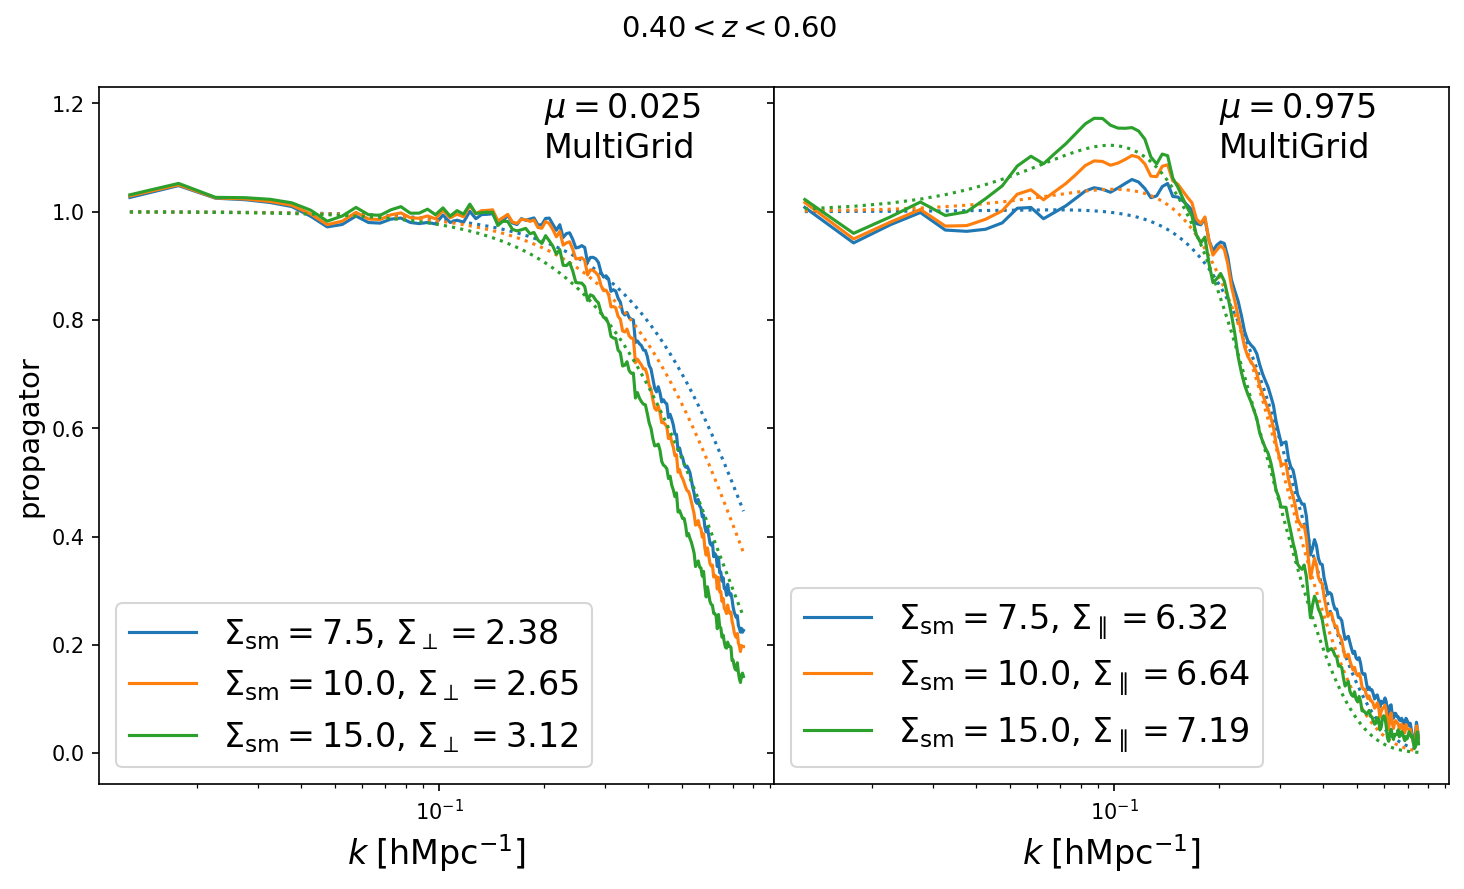

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,6), dpi=150)
plt.subplots_adjust(
    left=0.15,
    bottom=None,
    right=None,
    top=0.9,
    wspace=0.0,
    hspace=None,
)
for i, mu in enumerate(mu_list):
    for j, smooth_radius in enumerate(sm_radius_list):
        C_MG = propagator_list[j](k=k, mu=mu)
        C_app = cal_propagator(k, mu, beta, smooth_radius, convention, Sigma_xy_list[j], Sigma_z_list[j])
        axes[i].plot(k, C_MG, ls='-', color=f'C{j}', label=r"$\Sigma_{\mathrm{sm}}=%.1f$, $\Sigma_{\perp}=%.2f$"%(smooth_radius, Sigma_xy_list[j]) if i==0 else r"$\Sigma_{\mathrm{sm}}=%.1f$, $\Sigma_{\parallel}=%.2f$"%(smooth_radius, Sigma_z_list[j]))
        axes[i].plot(k, C_app, ls=':', color=f'C{j}')
    axes[i].set_xscale("log")
    axes[i].legend(loc="lower left", fontsize=16)
    axes[i].text(0.2, 1.1, r"$\mu=%.3f$"%(mu) + f"\n{recon_algo}", fontsize=16)
    axes[i].set_xlabel(r"$k\;\mathrm{[hMpc^{-1}]}$", fontsize=16)


axes[0].set_ylabel("propagator", fontsize=14)
fig.suptitle(r"${0:.2f}<z<{1:.2f}$".format(zmin, zmax), fontsize=14)
ofile = odir + f"propagator_BAO_damping_scales_{cap.upper()}_{recon_algo}_{convention}_{zmin}z{zmax}_mu0.025_0.975.png"
plt.savefig(ofile)